<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span><ul class="toc-item"><li><span><a href="#Линейная-регрессия" data-toc-modified-id="Линейная-регрессия-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Линейная регрессия</a></span></li><li><span><a href="#LGBMRegressor" data-toc-modified-id="LGBMRegressor-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>LGBMRegressor</a></span></li><li><span><a href="#Решающее-дерево" data-toc-modified-id="Решающее-дерево-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Решающее дерево</a></span></li><li><span><a href="#Решающий-лес" data-toc-modified-id="Решающий-лес-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>Решающий лес</a></span></li><li><span><a href="#CatBoostRegressor" data-toc-modified-id="CatBoostRegressor-4.5"><span class="toc-item-num">4.5&nbsp;&nbsp;</span>CatBoostRegressor</a></span></li></ul></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from lightgbm import LGBMRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error

In [2]:
taxi = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
taxi

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


In [3]:
taxi.sort_index(inplace=True)

In [4]:
taxi.index.is_monotonic

True

In [5]:
taxi.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB


In [6]:
taxi=taxi.resample('1H').sum()
taxi

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


Загрузили данные и провели ресемплирование их по одному часу.

## Анализ

In [7]:
taxi.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
num_orders    4416 non-null int64
dtypes: int64(1)
memory usage: 69.0 KB


Text(0.5, 1.0, 'Количество заказов по месяцам')

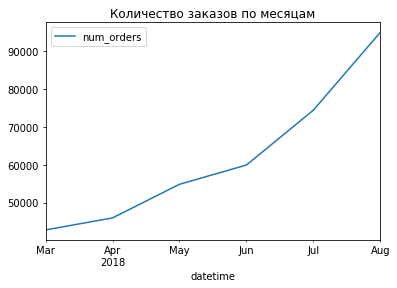

In [8]:
taxi.resample('1M').sum().plot()
plt.title('Количество заказов по месяцам')

Из графика следует, что количество заказов с каждым месяцем постепенно увеличивается, а данные представлены только по нескольким месяцам.

Это значит, что номер месяца и года не влияет на количество заказов.

In [9]:
decomposed = seasonal_decompose(taxi['2018-06-01':'2018-06-15']) 

Text(0.5, 1.0, 'Trend')

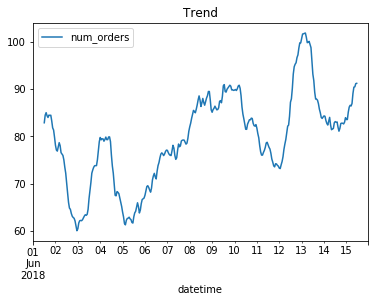

In [10]:
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')

Тренд нестабилен, однозназначные выводы сделать нельзя. Количество заказов на второй неделе немного увеличилось.

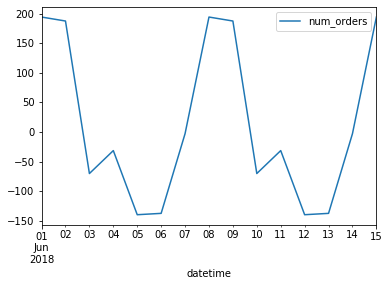

In [11]:
seasonal_decompose(taxi['2018-06-01':'2018-06-15'].resample('1D').sum()).seasonal.plot()

Среди недели количество заказов уменьшается, а в выходные и понедельник достигают пиковых значений.

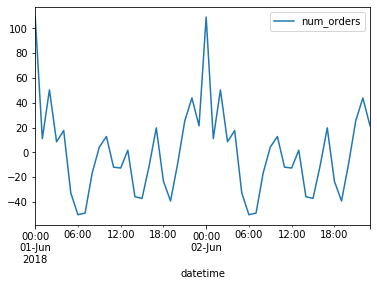

In [12]:
seasonal_decompose(taxi['2018-06-01':'2018-06-02']).seasonal.plot()

Большинство заказов приходится на полночь, также есть небольшие увеличения в утренний и вечерний час-пики.

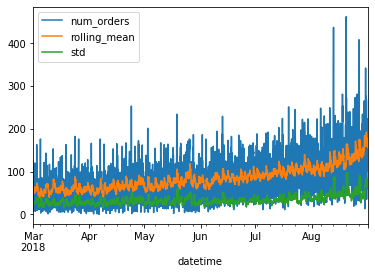

In [13]:
new_taxi=taxi.copy()

new_taxi['rolling_mean'] = taxi.rolling(20).mean()
new_taxi['std'] = taxi['num_orders'].rolling(20).std()
new_taxi.plot()

Количество заказов, скользящее среднее и стандартная ошибка постепенно увеличиваются. 

Text(0, 0.5, 'Заказы')

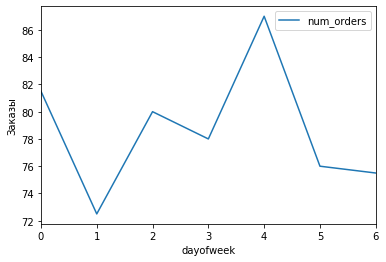

In [14]:
taxi['dayofweek'] = taxi.index.dayofweek
taxi.groupby('dayofweek').median().plot()
plt.ylabel('Заказы')

Text(0, 0.5, 'Заказы')

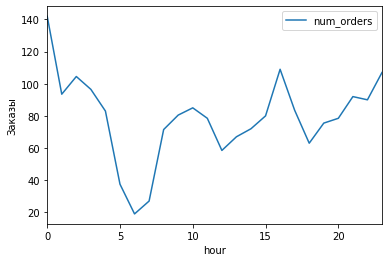

In [15]:
taxi['hour'] = taxi.index.hour
taxi[['hour','num_orders']].groupby('hour').median().plot()
plt.ylabel('Заказы')

## Обучение

In [16]:
def make_features(data, max_lag, rolling_mean_size):
    data['hour'] = data.index.hour
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

In [17]:
make_features(taxi,24,10)

Не совсем понял как __лучше__ подбирать аргументы для функции. На уме только цикл, который прогоняет все дальнейшие шаги до получения RMSE.

Пока выбрал отставание в месяц и смещение в неделю.

In [18]:
taxi

,num_orders,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,124.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,2,85.0,124.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,4,66.0,71.0,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,4,19,207.0,217.0,197.0,116.0,133.0,166.0,136.0,...,99.0,230.0,194.0,276.0,246.0,158.0,198.0,142.0,72.0,173.3
2018-08-31 20:00:00,154,4,20,136.0,207.0,217.0,197.0,116.0,133.0,166.0,...,268.0,99.0,230.0,194.0,276.0,246.0,158.0,198.0,142.0,166.6
2018-08-31 21:00:00,159,4,21,154.0,136.0,207.0,217.0,197.0,116.0,133.0,...,78.0,268.0,99.0,230.0,194.0,276.0,246.0,158.0,198.0,162.9


In [19]:
train, test = train_test_split(taxi, shuffle=False, test_size=0.1)

In [20]:
train = train.dropna()

In [21]:
target_train=train['num_orders']
target_test=test['num_orders']

features_train=train.drop(['num_orders'],axis=1)
features_test=test.drop(['num_orders'],axis=1)

## Тестирование

### Линейная регрессия

In [22]:
model=LinearRegression()

In [23]:
model.fit(features_train,target_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [24]:
predited=model.predict(features_test)
mean_squared_error(predited,target_test)**0.5

45.17810654807807

### LGBMRegressor

In [25]:
model = LGBMRegressor()

In [26]:
model.fit(features_train, target_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [27]:
predited=model.predict(features_test)
mean_squared_error(predited,target_test)**0.5

41.06960396809189

### Решающее дерево

In [28]:
model=DecisionTreeRegressor()

In [29]:
model.fit(features_train, target_train)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

In [30]:
predited=model.predict(features_test)
mean_squared_error(predited,target_test)**0.5

72.41584287048335

### Решающий лес

In [31]:
model=RandomForestRegressor()

In [32]:
model.fit(features_train, target_train)

/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [33]:
predited=model.predict(features_test)
mean_squared_error(predited,target_test)**0.5

46.099931046954254

### CatBoostRegressor

In [34]:
model = CatBoostRegressor(random_seed=12345,loss_function='RMSE')

In [35]:
model.fit(features_train, target_train)

0:	learn: 38.1484962	total: 51.4ms	remaining: 51.4s
1:	learn: 37.6174126	total: 54.9ms	remaining: 27.4s
2:	learn: 37.1410005	total: 121ms	remaining: 40.2s
3:	learn: 36.6523407	total: 134ms	remaining: 33.5s
4:	learn: 36.1994594	total: 146ms	remaining: 29s
5:	learn: 35.7401880	total: 223ms	remaining: 36.9s
6:	learn: 35.3087242	total: 233ms	remaining: 33s
7:	learn: 34.8806836	total: 318ms	remaining: 39.4s
8:	learn: 34.4680765	total: 327ms	remaining: 36s
9:	learn: 34.0448424	total: 412ms	remaining: 40.8s
10:	learn: 33.6312992	total: 423ms	remaining: 38s
11:	learn: 33.2668591	total: 434ms	remaining: 35.8s
12:	learn: 32.9260369	total: 522ms	remaining: 39.7s
13:	learn: 32.5821224	total: 531ms	remaining: 37.4s
14:	learn: 32.2186172	total: 613ms	remaining: 40.3s
15:	learn: 31.8733699	total: 621ms	remaining: 38.2s
16:	learn: 31.5670788	total: 630ms	remaining: 36.4s
17:	learn: 31.2752284	total: 715ms	remaining: 39s
18:	learn: 30.9748357	total: 730ms	remaining: 37.7s
19:	learn: 30.6816140	total: 8

In [36]:
predited=model.predict(features_test)
mean_squared_error(predited,target_test)**0.5

40.28001520294049

Перебрали несколько моделей и при помощи бустинга получили отклонение всего в 40 заказов.

Оптимальной моделью является CatBoostRegressor.

In [37]:
data=pd.DataFrame(list(zip(predited,target_test)),index=target_test.index,columns =['predited', 'target_test'])
data=data.sort_index()
data

,predited,target_test
datetime,,
2018-08-13 14:00:00,100.216421,102
2018-08-13 15:00:00,121.393672,175
2018-08-13 16:00:00,137.357115,144
2018-08-13 17:00:00,147.253889,152
2018-08-13 18:00:00,123.824600,104
...,...,...
2018-08-31 19:00:00,127.470917,136
2018-08-31 20:00:00,144.170009,154
2018-08-31 21:00:00,174.995374,159


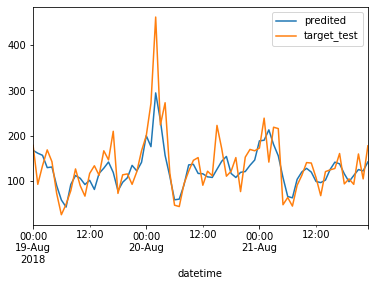

In [38]:
data['2018-08-19':'2018-08-21'].plot()

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Данные проанализированы
- [x]  Модель обучена, гиперпараметры подобраны
- [x]  Качество моделей проверено, выводы сделаны
- [x]  Значение *RMSE* на тестовой выборке не больше 48